# Assumptions:


**- Data for India has been scraped from http://covid19india.org**

**- The modeling is based on USA and Europe top 5 affected countries' data. China's data hasn't been considered into the modeling**

**- The modeling has been done with all data updated till 19th April, 2020**

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Data Pre-processing

In [40]:
df_ind_main = pd.read_excel('COVID19 India Complete Dataset April 2020.xlsx', sheet_name='Raw Data')
df_ind_main.head(2)

,Patient Number,State Patient Number,Date Announced,Estimated Onset Date,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Backup Notes
0,1,KL-TS-P1,2020-01-30,NaN,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
1,2,KL-AL-P1,2020-02-02,NaN,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan


In [41]:
df_ind_main = df_ind_main.dropna(subset=['Date Announced'])
df_ind_main.reset_index(drop=True)
df_ind_main = df_ind_main.drop_duplicates(subset=df_ind_main.drop('Patient Number', axis=1).columns)
df_ind_main.reset_index(drop=True)
df_ind_main.head(2)

,Patient Number,State Patient Number,Date Announced,Estimated Onset Date,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Backup Notes
0,1,KL-TS-P1,2020-01-30,NaN,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
1,2,KL-AL-P1,2020-02-02,NaN,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan


In [42]:
dbd_tc_india = pd.read_excel('COVID19 India Complete Dataset April 2020.xlsx', sheet_name='Daily Cases Time-Series')
dbd_tc_india.head(2)

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
0,2020-01-30,1,1,0,0,0,0
1,2020-01-31,0,1,0,0,0,0


In [43]:
db_india = pd.DataFrame(dbd_tc_india.groupby(['Date'])['Total Confirmed'].sum()).reset_index()
db_india.head(3)

,Date,Total Confirmed
0,2020-01-30,1
1,2020-01-31,1
2,2020-02-01,1


In [44]:
dbd_tc_param = pd.DataFrame(dbd_tc_india.groupby(['Date'])['Total Confirmed','Total Recovered', \
                                                           'Total Deceased'].sum().reset_index())
dbd_tc_param.head(3)

,Date,Total Confirmed,Total Recovered,Total Deceased
0,2020-01-30,1,0,0
1,2020-01-31,1,0,0
2,2020-02-01,1,0,0


In [45]:
dbd_tc_param['Total Active Cases'] = dbd_tc_param['Total Confirmed'] - dbd_tc_param['Total Recovered'] - \
                                     dbd_tc_param['Total Deceased']

In [46]:
dbd_india_count = dbd_tc_param.copy()

In [47]:
dbd_tc_pl = dbd_tc_param[(dbd_tc_param['Date']>'2020-03-01') & (dbd_tc_param['Date']<'2020-03-25')].reset_index(drop=True) # considering pre lockdown period
dbd_tc_pl.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-02,5,3,0,2
1,2020-03-03,6,3,0,3


In [48]:
dbd_tc_pl.tail(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
21,2020-03-23,497,25,9,463
22,2020-03-24,571,40,10,521


In [49]:
dbd_tc_pl.shape

(23, 5)

In [50]:
dbd_tc_param['Total Active Cases'] = dbd_tc_param['Total Confirmed'] - dbd_tc_param['Total Recovered'] - \
                                     dbd_tc_param['Total Deceased']

In [51]:
dbd_tc_param = dbd_tc_param[dbd_tc_param['Date']>='2020-03-25'].reset_index(drop=True) # considering from lockdown date
dbd_tc_param.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-25,657,43,11,603
1,2020-03-26,730,50,16,664


In [52]:
dbd_tc_param.tail(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
24,2020-04-18,15724,2466,521,12737
25,2020-04-19,17304,2854,559,13891


In [53]:
dbd_tc_param.shape

(26, 5)

In [54]:
df_ind_main.head(3)

,Patient Number,State Patient Number,Date Announced,Estimated Onset Date,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Backup Notes
0,1,KL-TS-P1,2020-01-30,NaN,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
1,2,KL-AL-P1,2020-02-02,NaN,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Student from Wuhan
2,3,KL-KS-P1,2020-02-03,NaN,NaN,NaN,Kasaragod,Kasaragod,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,2020-02-14,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,Student from Wuhan


In [55]:
dbd_tc_pl.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-02,5,3,0,2
1,2020-03-03,6,3,0,3


In [56]:
dbd_tc_pl.tail(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
21,2020-03-23,497,25,9,463
22,2020-03-24,571,40,10,521


# SIR Modeling

## Initial Population (Potentially Exposed) Estimation for SIR Modeling

### Global Testing Data 

In [57]:
df_w_testing = pd.read_csv('full-list-total-tests-for-covid-19-world.txt', sep=',')
df_w_testing.head(2)

,Entity,Code,Date,Total tests
0,Argentina,ARG,"Apr 8, 2020",13330
1,Argentina,ARG,"Apr 9, 2020",14850


In [58]:
df_w_testing['Entity'].unique()

array(['Argentina', 'Australia', 'Austria', 'Bahrain', 'Bangladesh',
       'Belgium', 'Bolivia', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
       'Cuba', 'Czech Republic', 'Denmark', 'Ecuador', 'El Salvador',
       'Estonia', 'Ethiopia', 'Finland', 'France', 'Germany', 'Ghana',
       'Greece', 'Hong Kong', 'Hungary', 'Iceland', 'India',
       'India, people tested', 'Indonesia', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Japan, tests performed', 'Kenya', 'Latvia', 'Lithuania',
       'Luxembourg', 'Malaysia', 'Mexico', 'Nepal', 'Netherlands',
       'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Panama',
       'Paraguay', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Romania',
       'Russia', 'Senegal', 'Serbia', 'Singapore',
       'Singapore, swabs tested', 'Slovakia', 'Slovenia', 'South Africa',
       'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan',
       'Thailand', 'Tunisia', 'Turkey', 'Uganda', 'United Kingdom',
       'United States', 'United States, s

In [59]:
# USA, UK, France, Italy, Spain, Germany

df_w_testing = df_w_testing[(df_w_testing['Entity']=='Italy') | (df_w_testing['Entity']=='France') | \
                            (df_w_testing['Entity']=='Germany') | (df_w_testing['Entity']=='United Kingdom') | \
                            (df_w_testing['Entity']=='United States') | (df_w_testing['Entity']=='Spain') | \
                            (df_w_testing['Entity']=='India') | (df_w_testing['Entity']=='South Korea') | \
                            (df_w_testing['Entity']=='Japan')]

In [60]:
df_w_testing['Date'] = pd.to_datetime(df_w_testing['Date'])
df_w_testing.reset_index(drop=True, inplace=True)
df_w_testing.head(2)

,Entity,Code,Date,Total tests
0,France,FRA,2020-02-24,31
1,France,FRA,2020-02-25,146


In [61]:
df_fra = df_w_testing[df_w_testing['Entity'] == 'France']
df_ita = df_w_testing[df_w_testing['Entity'] == 'Italy']
df_spa = df_w_testing[df_w_testing['Entity'] == 'Spain']
df_uk = df_w_testing[df_w_testing['Entity'] == 'United Kingdom']
df_us = df_w_testing[df_w_testing['Entity'] == 'United States']
df_ger = df_w_testing[df_w_testing['Entity'] == 'Germany']
df_jap = df_w_testing[df_w_testing['Entity'] == 'Japan']
df_skr = df_w_testing[df_w_testing['Entity'] == 'South Korea']

In [62]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df_fra['Date'], y=df_fra['Total tests'], name='France', \
                         ))
fig1.add_trace(go.Scatter(x=df_ita['Date'], y=df_ita['Total tests'], name='Italy', \
                         ))
fig1.add_trace(go.Scatter(x=df_spa['Date'], y=df_spa['Total tests'], name='Spain', \
                         ))
fig1.add_trace(go.Scatter(x=df_uk['Date'], y=df_uk['Total tests'], name='UK', \
                         ))
fig1.add_trace(go.Scatter(x=df_us['Date'], y=df_us['Total tests'], name='USA', \
                         ))
fig1.add_trace(go.Scatter(x=df_ger['Date'], y=df_ger['Total tests'], name='Germany', \
                         ))
fig1.add_trace(go.Scatter(x=df_jap['Date'], y=df_jap['Total tests'], name='Japan', \
                         ))
fig1.add_trace(go.Scatter(x=df_skr['Date'], y=df_skr['Total tests'], name='South Korea', \
                         ))

fig1.layout.update(title_text='Total no. of tests done in Europe, US, Japan & South Korea',xaxis_showgrid=False, width=800, xaxis_title='Date',\
                yaxis_showgrid=False, yaxis_title='No. of Tests Done',
        height=600,font=dict(
#         family="Courier New, monospace",
        size=14,
        color="white"
    ))
fig1.layout.plot_bgcolor = '#030301'
fig1.layout.paper_bgcolor = '#030301'
fig1.show()

In [63]:
df_ind = df_w_testing[df_w_testing['Entity']=='India']
df_ind.head(2)

,Entity,Code,Date,Total tests
27,India,IND,2020-03-13,6500
28,India,IND,2020-03-18,13125


In [64]:
fig_ind = go.Figure()
fig_ind.add_trace(go.Scatter(x=df_ind['Date'], y=df_ind['Total tests'], name='India', \
                        ))

fig_ind.layout.update(title_text='Total no. of tests done in India',xaxis_showgrid=False, width=800, xaxis_title='Date',\
                yaxis_showgrid=False, yaxis_title='No. of Tests Done',
        height=600,font=dict(
#         family="Courier New, monospace",
        size=14,
        color="white"
    ))
fig_ind.layout.plot_bgcolor = '#030301'
fig_ind.layout.paper_bgcolor = '#030301'
fig_ind.show()

In [66]:
ncov_df = pd.read_csv('covid_19_data.csv')
ncov_df['ObservationDate'] = pd.to_datetime(ncov_df['ObservationDate']) 

ncov_df["Country"] = ncov_df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
    }
)
ncov_df["Province"] = ncov_df["Province/State"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess cruise ship",
        "Diamond Princess": "Diamond Princess cruise ship"
    }
)
ncov_df.head(2)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Country,Province
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1,0,0,China,Anhui
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14,0,0,China,Beijing


In [67]:
ncov_italy = ncov_df[ncov_df['Country'] == 'Italy']
ncov_us = ncov_df[ncov_df['Country'] == 'US']
ncov_spain = ncov_df[ncov_df['Country'] == 'Spain']
ncov_germany = ncov_df[ncov_df['Country'] == 'Germany']
ncov_iran = ncov_df[ncov_df['Country'] == 'Iran']
ncov_france = ncov_df[ncov_df['Country'] == 'France']
ncov_uk = ncov_df[ncov_df['Country'] == 'UK']
ncov_swiss = ncov_df[ncov_df['Country'] == 'Switzerland']
ncov_soukor = ncov_df[ncov_df['Country'] == 'South Korea']

ncov_italy = pd.DataFrame(ncov_italy.groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum()).reset_index()
ncov_us = pd.DataFrame(ncov_us.groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum()).reset_index()
ncov_spain = pd.DataFrame(ncov_spain.groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum()).reset_index()
ncov_germany = pd.DataFrame(ncov_germany.groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum()).reset_index()
ncov_iran = pd.DataFrame(ncov_iran.groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum()).reset_index()
ncov_france = pd.DataFrame(ncov_france.groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum()).reset_index()
ncov_uk = pd.DataFrame(ncov_uk.groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum()).reset_index()
ncov_swiss = pd.DataFrame(ncov_swiss.groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum()).reset_index()
ncov_soukor = pd.DataFrame(ncov_soukor.groupby(['ObservationDate'])['Confirmed', 'Deaths', 'Recovered'].sum()).reset_index()

In [68]:
ncov_italy.head(2)

,ObservationDate,Confirmed,Deaths,Recovered
0,2020-01-31,2,0,0
1,2020-02-01,2,0,0


### Calculating Positive:Tests Percentage for Europe & US

For ex. if its 1 out of 100 people tested turn out to be positive, then Positve:Tests is 1%

In [69]:
# merging based only on testing data available

df_fra_rate = pd.merge(df_fra[['Date', 'Total tests']], ncov_france[['ObservationDate', 'Confirmed']], left_on=['Date'], \
         right_on=['ObservationDate'], how='left')
df_ita_rate = pd.merge(df_ita[['Date', 'Total tests']], ncov_italy[['ObservationDate', 'Confirmed']], left_on=['Date'], \
         right_on=['ObservationDate'], how='left')
df_ger_rate = pd.merge(df_ger[['Date', 'Total tests']], ncov_germany[['ObservationDate', 'Confirmed']], left_on=['Date'], \
         right_on=['ObservationDate'], how='left')
df_us_rate = pd.merge(df_us[['Date', 'Total tests']], ncov_us[['ObservationDate', 'Confirmed']], left_on=['Date'], \
         right_on=['ObservationDate'], how='left')
df_uk_rate = pd.merge(df_uk[['Date', 'Total tests']], ncov_uk[['ObservationDate', 'Confirmed']], left_on=['Date'], \
         right_on=['ObservationDate'], how='left')
df_spa_rate = pd.merge(df_spa[['Date', 'Total tests']], ncov_spain[['ObservationDate', 'Confirmed']], left_on=['Date'], \
         right_on=['ObservationDate'], how='left')

In [70]:
df_fra_rate['positive_percentage'] = round(df_fra_rate['Confirmed']/df_fra_rate['Total tests'], 2)
df_ita_rate['positive_percentage'] = round(df_ita_rate['Confirmed']/df_ita_rate['Total tests'], 2)
df_ger_rate['positive_percentage'] = round(df_ger_rate['Confirmed']/df_ger_rate['Total tests'], 2)
df_us_rate['positive_percentage'] = round(df_us_rate['Confirmed']/df_us_rate['Total tests'], 2)
df_uk_rate['positive_percentage'] = round(df_uk_rate['Confirmed']/df_uk_rate['Total tests'], 2)
df_spa_rate['positive_percentage'] = round(df_spa_rate['Confirmed']/df_spa_rate['Total tests'], 2)

In [71]:
df_rate = pd.DataFrame(['France', 'Italy', 'Germany', 'USA', 'UK', 'Spain']).rename(columns={0:'Country'})
df_rate['positive_percentage_mean'] = [df_fra_rate['positive_percentage'].mean(), df_ita_rate['positive_percentage'].mean(), \
                                  df_ger_rate['positive_percentage'].mean(), df_us_rate['positive_percentage'].mean(), \
                                  df_uk_rate['positive_percentage'].mean(), df_spa_rate['positive_percentage'].mean()]
df_rate['positive_percentage_mean'] = df_rate['positive_percentage_mean']*100
df_rate['positive_percentage_mean'] = df_rate['positive_percentage_mean'].round(2)
df_rate

,Country,positive_percentage_mean
0,France,12.57
1,Italy,16.31
2,Germany,4.50
3,USA,16.79
4,UK,8.80
5,Spain,18.00


In [72]:
df_ind_rate = pd.read_excel('COVID19 India Complete Dataset April 2020.xlsx', sheet_name='ICMR Testing Count')
df_ind_rate.head(2)

,Update Time Stamp,Total Samples Tested,Total Individuals Tested,Total Positive Cases,Tests conducted by Private Labs,Sample Reported today,Positive cases from samples reported,Source
0,2020-03-13 00:00:00,6500.0,5900.0,78.0,NaN,NaN,NaN,Press_Release_ICMR_13March2020.pdf
1,2020-03-18 18:00:00,13125.0,12235.0,150.0,NaN,NaN,NaN,ICMR_website_update_18March_6PM_IST.pdf


In [73]:
df_ind_rate = df_ind_rate.dropna(subset=['Total Positive Cases']).reset_index(drop=True)
df_ind_rate['Total Individuals Tested'].fillna(df_ind_rate['Total Samples Tested']-900, inplace=True)
df_ind_rate['positive_percentage'] = round(df_ind_rate['Total Positive Cases']/df_ind_rate['Total Individuals Tested'], 5)
df_ind_rate.head(2)

,Update Time Stamp,Total Samples Tested,Total Individuals Tested,Total Positive Cases,Tests conducted by Private Labs,Sample Reported today,Positive cases from samples reported,Source,positive_percentage
0,2020-03-13 00:00:00,6500.0,5900.0,78.0,NaN,NaN,NaN,Press_Release_ICMR_13March2020.pdf,0.01322
1,2020-03-18 18:00:00,13125.0,12235.0,150.0,NaN,NaN,NaN,ICMR_website_update_18March_6PM_IST.pdf,0.01226


In [74]:
df_ind_rate_count = pd.DataFrame(['India']).rename(columns={0:'Country'})
df_ind_rate_count['positive_percentage_mean'] = round(df_ind_rate.loc[len(df_ind_rate)-1]['positive_percentage']*100, 2)

In [75]:
df_rate = pd.concat([df_rate, df_ind_rate_count], ignore_index=True)
df_rate

,Country,positive_percentage_mean
0,France,12.57
1,Italy,16.31
2,Germany,4.50
3,USA,16.79
4,UK,8.80
5,Spain,18.00
6,India,4.59


#### Positive Percentage in Testing India v Europe & USA

In [76]:
fig = px.bar(df_rate.sort_values(by=['positive_percentage_mean'], ascending=False), x='Country', y='positive_percentage_mean',
            title='Mean Percentage of Positive Cases in Testing')
fig.show()

In [77]:
df_rate_row = df_rate[df_rate['Country']!='India'] # working with rest of world

df_rate_row['population'] = 0
df_rate_row['lockdown_date'] = 0
df_rate_row['cases_on_lockdowndate'] = 0
df_rate_row['cases_2weeks_in_lockdown'] = 0
df_rate_row['total_cases'] = 0

In [78]:
df_rate_row.loc[df_rate_row['Country']=='Italy', 'population'] = 60400000
df_rate_row.loc[df_rate_row['Country']=='USA', 'population'] = 338200000
df_rate_row.loc[df_rate_row['Country']=='UK', 'population'] = 66000000
df_rate_row.loc[df_rate_row['Country']=='France', 'population'] = 67000000
df_rate_row.loc[df_rate_row['Country']=='Spain', 'population'] = 46900000
df_rate_row.loc[df_rate_row['Country']=='Germany', 'population'] = 83000000

df_rate_row.loc[df_rate_row['Country']=='Italy', 'total_cases'] = 178972
df_rate_row.loc[df_rate_row['Country']=='USA', 'total_cases'] = 759786
df_rate_row.loc[df_rate_row['Country']=='UK', 'total_cases'] = 121173
df_rate_row.loc[df_rate_row['Country']=='Spain', 'total_cases'] = 198674
df_rate_row.loc[df_rate_row['Country']=='France', 'total_cases'] = 154098
df_rate_row.loc[df_rate_row['Country']=='Germany', 'total_cases'] = 145743

In [79]:
df_rate_row.loc[df_rate_row['Country']=='Italy', 'lockdown_date'] = '2020-03-09'
df_rate_row.loc[df_rate_row['Country']=='USA', 'lockdown_date'] = np.NaN
df_rate_row.loc[df_rate_row['Country']=='UK', 'lockdown_date'] = '2020-03-19'
df_rate_row.loc[df_rate_row['Country']=='Spain', 'lockdown_date'] = '2020-03-14'
df_rate_row.loc[df_rate_row['Country']=='France', 'lockdown_date'] = '2020-03-17'
df_rate_row.loc[df_rate_row['Country']=='Germany', 'lockdown_date'] = '2020-03-22'

In [80]:
# lockdown dates were googled

df_rate_row.loc[df_rate_row['Country']=='Italy', 'lockdown_date'] = '2020-03-09'
df_rate_row.loc[df_rate_row['Country']=='USA', 'lockdown_date'] = np.NaN
df_rate_row.loc[df_rate_row['Country']=='UK', 'lockdown_date'] = '2020-03-19'
df_rate_row.loc[df_rate_row['Country']=='Spain', 'lockdown_date'] = '2020-03-14'
df_rate_row.loc[df_rate_row['Country']=='France', 'lockdown_date'] = '2020-03-17'
df_rate_row.loc[df_rate_row['Country']=='Germany', 'lockdown_date'] = '2020-03-22'

In [81]:
df_rate_row.loc[df_rate_row['Country']=='Italy', 'cases_on_lockdowndate'] = 9172
df_rate_row.loc[df_rate_row['Country']=='USA', 'cases_on_lockdowndate'] = np.NaN
df_rate_row.loc[df_rate_row['Country']=='UK', 'cases_on_lockdowndate'] = 2716
df_rate_row.loc[df_rate_row['Country']=='Spain', 'cases_on_lockdowndate'] = 6391
df_rate_row.loc[df_rate_row['Country']=='France', 'cases_on_lockdowndate'] = 7683
df_rate_row.loc[df_rate_row['Country']=='Germany', 'cases_on_lockdowndate'] = 25000

In [82]:
# considering a max. of 2 week incubation period for Covid

df_rate_row.loc[df_rate_row['Country']=='Italy', 'cases_2weeks_in_lockdown'] = 64000
df_rate_row.loc[df_rate_row['Country']=='USA', 'cases_2weeks_in_lockdown'] = np.NaN
df_rate_row.loc[df_rate_row['Country']=='UK', 'cases_2weeks_in_lockdown'] = 39000
df_rate_row.loc[df_rate_row['Country']=='Spain', 'cases_2weeks_in_lockdown'] = 73000
df_rate_row.loc[df_rate_row['Country']=='France', 'cases_2weeks_in_lockdown'] = 53000
df_rate_row.loc[df_rate_row['Country']=='Germany', 'cases_2weeks_in_lockdown'] = 100000

In [83]:
df_rate_row.rename(columns={'positive_percentage_mean':'testing_positive_percentage_mean'}, inplace=True)
df_rate_row

,Country,testing_positive_percentage_mean,population,lockdown_date,cases_on_lockdowndate,cases_2weeks_in_lockdown,total_cases
0,France,12.57,67000000,2020-03-17,7683.0,53000.0,154098
1,Italy,16.31,60400000,2020-03-09,9172.0,64000.0,178972
2,Germany,4.50,83000000,2020-03-22,25000.0,100000.0,145743
3,USA,16.79,338200000,NaN,NaN,NaN,759786
4,UK,8.80,66000000,2020-03-19,2716.0,39000.0,121173
5,Spain,18.00,46900000,2020-03-14,6391.0,73000.0,198674


In [84]:
df_rate_ind = df_rate[df_rate['Country']=='India']

In [85]:
df_rate_ind.rename(columns={'positive_percentage_mean':'testing_positive_percentage_mean'}, inplace=True)

In [86]:
df_rate_ind['population'] = 1350000000
df_rate_ind['lockdown_date'] = '2020-03-25'
df_rate_ind['cases_on_lockdowndate'] = 521
df_rate_ind['cases_2weeks_in_lockdown'] = 5168
df_rate_ind

,Country,testing_positive_percentage_mean,population,lockdown_date,cases_on_lockdowndate,cases_2weeks_in_lockdown
6,India,4.59,1350000000,2020-03-25,521,5168


In [87]:
df_rate_row['%_affected_population'] = round((df_rate_row['total_cases']/df_rate_row['population'])*100, 2)

df_rate_row['%case_growth_in_2weeks_lockdown'] = round(((df_rate_row['cases_2weeks_in_lockdown']-\
                                            df_rate_row['cases_on_lockdowndate'])/df_rate_row['cases_on_lockdowndate'])*100, 2)
df_rate_ind['%case_growth_in_2weeks_lockdown'] = round(((df_rate_ind['cases_2weeks_in_lockdown']-\
                                            df_rate_ind['cases_on_lockdowndate'])/df_rate_ind['cases_on_lockdowndate'])*100, 2)

df_rate_row['%_final_growth'] = round(((df_rate_row['total_cases']-\
                                        df_rate_row['cases_2weeks_in_lockdown'])/df_rate_row['cases_2weeks_in_lockdown'])*100, 2)

In [88]:
df_rate_row

,Country,testing_positive_percentage_mean,population,lockdown_date,cases_on_lockdowndate,cases_2weeks_in_lockdown,total_cases,%_affected_population,%case_growth_in_2weeks_lockdown,%_final_growth
0,France,12.57,67000000,2020-03-17,7683.0,53000.0,154098,0.23,589.83,190.75
1,Italy,16.31,60400000,2020-03-09,9172.0,64000.0,178972,0.30,597.78,179.64
2,Germany,4.50,83000000,2020-03-22,25000.0,100000.0,145743,0.18,300.00,45.74
3,USA,16.79,338200000,NaN,NaN,NaN,759786,0.22,NaN,NaN
4,UK,8.80,66000000,2020-03-19,2716.0,39000.0,121173,0.18,1335.94,210.70
5,Spain,18.00,46900000,2020-03-14,6391.0,73000.0,198674,0.42,1042.23,172.16


In [89]:
df_rate_row['%_testing_increase_in_2weeks_lockdown'] = 0

# getting these values from testing data, 2 weeks post lockdown date - lockdown date gives testing count for 2 weeks during
# lockdown

df_rate_row.loc[df_rate_row['Country']=='France', '%_testing_increase_in_2weeks_lockdown'] = 510.26
df_rate_row.loc[df_rate_row['Country']=='USA', '%_testing_increase_in_2weeks_lockdown'] = np.NaN
df_rate_row.loc[df_rate_row['Country']=='Italy', '%_testing_increase_in_2weeks_lockdown'] = 411.77
df_rate_row.loc[df_rate_row['Country']=='Germany', '%_testing_increase_in_2weeks_lockdown'] = 127.74
df_rate_row.loc[df_rate_row['Country']=='Spain', '%_testing_increase_in_2weeks_lockdown'] = np.NaN
df_rate_row.loc[df_rate_row['Country']=='UK', '%_testing_increase_in_2weeks_lockdown'] = 168.93

In [90]:
df_rate_ind['%_testing_increase_in_2weeks_lockdown'] = 427.41
df_rate_ind['total_tests_done'] = 372123
df_rate_ind['tests_before_lockdown'] = 24254
df_rate_ind

,Country,testing_positive_percentage_mean,population,lockdown_date,cases_on_lockdowndate,cases_2weeks_in_lockdown,%case_growth_in_2weeks_lockdown,%_testing_increase_in_2weeks_lockdown,total_tests_done,tests_before_lockdown
6,India,4.59,1350000000,2020-03-25,521,5168,891.94,427.41,372123,24254


In [91]:
df_rate_row.loc[df_rate_row['Country']=='France', 'total_tests_done'] = 463662
df_rate_row.loc[df_rate_row['Country']=='USA', 'total_tests_done'] = 3698534
df_rate_row.loc[df_rate_row['Country']=='Italy', 'total_tests_done'] = 1305833
df_rate_row.loc[df_rate_row['Country']=='Germany', 'total_tests_done'] = 1728357
df_rate_row.loc[df_rate_row['Country']=='Spain', 'total_tests_done'] = 930230
df_rate_row.loc[df_rate_row['Country']=='UK', 'total_tests_done'] = 372967

In [92]:
df_rate_row.loc[df_rate_row['Country']=='France', 'tests_before_lockdown'] = 36747
df_rate_row.loc[df_rate_row['Country']=='USA', 'tests_before_lockdown'] = np.NaN
df_rate_row.loc[df_rate_row['Country']=='Italy', 'tests_before_lockdown'] = 53826
df_rate_row.loc[df_rate_row['Country']=='Germany', 'tests_before_lockdown'] = 600792
df_rate_row.loc[df_rate_row['Country']=='Spain', 'tests_before_lockdown'] = np.NaN
df_rate_row.loc[df_rate_row['Country']=='UK', 'tests_before_lockdown'] = 5207

In [93]:
df_rate_row = df_rate_row[['Country', 'population', 'total_cases', 'total_tests_done', 
                           'testing_positive_percentage_mean','lockdown_date','cases_on_lockdowndate', 
                           'tests_before_lockdown', '%case_growth_in_2weeks_lockdown', '%_testing_increase_in_2weeks_lockdown', 
                           '%_final_growth', '%_affected_population']]

In [94]:
df_rate_ind['total_cases'] = 13891
df_rate_ind = df_rate_ind[['Country', 'population', 'total_cases', 'total_tests_done', 'testing_positive_percentage_mean',
                           'lockdown_date', 'cases_on_lockdowndate', 'tests_before_lockdown', '%case_growth_in_2weeks_lockdown', 
                           '%_testing_increase_in_2weeks_lockdown']]

In [95]:
df_rate_row

,Country,population,total_cases,total_tests_done,testing_positive_percentage_mean,lockdown_date,cases_on_lockdowndate,tests_before_lockdown,%case_growth_in_2weeks_lockdown,%_testing_increase_in_2weeks_lockdown,%_final_growth,%_affected_population
0,France,67000000,154098,463662.0,12.57,2020-03-17,7683.0,36747.0,589.83,510.26,190.75,0.23
1,Italy,60400000,178972,1305833.0,16.31,2020-03-09,9172.0,53826.0,597.78,411.77,179.64,0.30
2,Germany,83000000,145743,1728357.0,4.50,2020-03-22,25000.0,600792.0,300.00,127.74,45.74,0.18
3,USA,338200000,759786,3698534.0,16.79,NaN,NaN,NaN,NaN,NaN,NaN,0.22
4,UK,66000000,121173,372967.0,8.80,2020-03-19,2716.0,5207.0,1335.94,168.93,210.70,0.18
5,Spain,46900000,198674,930230.0,18.00,2020-03-14,6391.0,NaN,1042.23,NaN,172.16,0.42


In [96]:
df_rate_ind.reset_index(drop=True, inplace=True)
df_rate_ind

,Country,population,total_cases,total_tests_done,testing_positive_percentage_mean,lockdown_date,cases_on_lockdowndate,tests_before_lockdown,%case_growth_in_2weeks_lockdown,%_testing_increase_in_2weeks_lockdown
0,India,1350000000,13891,372123,4.59,2020-03-25,521,24254,891.94,427.41


In [97]:
df_rate_row['testing_positive_rate_prelockdown'] = round(df_rate_row['cases_on_lockdowndate']\
                                                         /df_rate_row['tests_before_lockdown'], 2)
df_rate_row['testing_positive_rate_2weeks_inlockdown'] = round(df_rate_row['cases_on_lockdowndate']\
                                                         /df_rate_row['tests_before_lockdown'], 2)

In [98]:
print('Mean of the Avg. Testing Positive % in Europe & USA combined =', \
      round(df_rate_row['testing_positive_percentage_mean'].mean(), 2))

Mean of the Avg. Testing Positive % in Europe & USA combined = 12.83


In [99]:
print('Avg. Testing Positive % in India =', \
      round(df_rate_ind['testing_positive_percentage_mean'].values[0], 2))

Avg. Testing Positive % in India = 4.59


In [100]:
print('Mean growth % for 2 weeks across Europe & USA starting after 2 weeks of lockdown',\
      round(df_rate_row['%_final_growth'].mean(), 2))

Mean growth % for 2 weeks across Europe & USA starting after 2 weeks of lockdown 159.8


In [101]:
print('Mean growth % for 2 weeks in India starting after 2 weeks of lockdown',round(((18543-5168)/5168)*100, 2)) 

Mean growth % for 2 weeks in India starting after 2 weeks of lockdown 258.8


In [102]:
# total population affected in each country as on 19th April

affected_percent_korea = 0.02 # south korea
affected_percent_japan = 0.008
affected_percent_singapore = 0.2
affected_percent_china = 0.006
affected_percent_france = 0.23
affected_percent_italy = 0.30
affected_percent_germany = 0.18
affected_percent_usa = 0.22
affected_percent_uk = 0.18
affected_percent_spain = 0.42

In [103]:
print("Mean % population affected in Western Countries (Europe & US):", round(((affected_percent_france+affected_percent_italy+\
affected_percent_germany+affected_percent_usa+affected_percent_uk+affected_percent_spain)/6), 2))

Mean % population affected in Western Countries (Europe & US): 0.25


In [104]:
print("Mean % population affected in Asian Countries:", round(((affected_percent_japan+affected_percent_singapore+\
affected_percent_korea+affected_percent_china)/4), 2))

Mean % population affected in Asian Countries: 0.06


#### Assumptions for S_0 (Initial Susceptible Population for India) during:

Since Europe is currently recovering as cases have started to gone down and the same in the Asian countries, I expect 0.25 to go
upto 0.30 at max. based on the and Asia upto 0.08, because of the no. of cases each of them have been reporting.

Based on the above assumptions here's the Indian population that might get affected:

- Max: 0.003*135 Crore; 0.3% = 0.003
- Min: 0.0008*135 Crore; 0.08% = 0.0008

"Please note that Europe & USA are the countries contributing maximum to the total no. of cases globally so I have tried to keep
the figures on the higher side"

The maximum value range turns out to be 4.05 million which turns out to be pretty much unrealistic right now based on the current
stage that we are in, hence I'll go ahead with the manipulation on the minimum value first, so base value that we have is 8% of 
135 crore, i.e. 1.08 million. The population of India is ~200 per sq. km. while that of Europe is ~143 per sq. km. Now, 
considering multiple factors like, the early declaration of lockdown, no. of people tested positive percentage being low as 
compared to other countries, the mean age group in India being much lesser than that of Europe. I assume that only 50% of the
current population size can actually get affected, i.e. to 0.54 million. A last few factors which I considered in the back of my
mind which might be debatable are like: corona virus started off with people having travel history and then gradually spreading 
through community transmission. India is a country where many parts are still under developed, people in those places don't have 
the priviledge to go anywhere outside their place and neither do anyone from outside visit their places as there is no industrial
benefits available. There are no airports, no movie theatres, shopping malls or party halls where mass gathering can happen. 
Also, since the mean age of the population of India is lesser compared to Europe & USA as well as the climate being more hot and
humid which makes difficult for the corona virus to transmit easily I assume that Indians have a stronger immuntiy as a mass
and are more prone to diseases like these earlier. Also as per the Indian Govt. almost 30% of the existing cases have generated
from the religious event that happened in Delhi post lockdown and except that there has been no record of community transmission
happening anywhere else in India.

Based on the above considerations and the existing current trend in the number of cases I select my population that could have 
actually come in contact with corona: 

i) Best case scenario: 75000

ii) Worst case scenario: 1,50,000

The above figures correspond to the population till 25th March. I assume the exposed population does not increase with time 
because of the existing lockdown that started on 25th March.

Note: The assumptions are based on my intuitions and it may or may not be correct. However, the population can change drastically based on the rate of testing currently persisting



- Pre-Lockdown Period Population = 30,000 (1st Mar - 24th Mar)
- During Lockdown Period Population = [75,000 - 1,50,000] (25th Mar - 19th April)

## Parameters (Beta & Gamma) Estimation for SIR Modeling

### Whole India Covid Scenarios during Pre-Lockdown and Lockdown

#### Loss Funciton for optimizing Beta and Gamma

In [105]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

#### Pre-Lockdown Period

In [106]:
data = dbd_tc_pl.set_index('Date')['Total Active Cases']
infected = dbd_tc_pl.set_index('Date')['Total Confirmed']
recovered = dbd_tc_pl.set_index('Date')['Total Recovered']

##### Defining Initial Values 

In [107]:
s_0 = 30000
i_0 = 2
r_0 = 3

##### Defining Loss Function for our Model

In [108]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [109]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = list(data.index.values)
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

In [110]:
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Actual Infected': extended_actual, 'Actual Recovered': extended_recovered, 'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('India')
    df.plot(ax=ax)
    print(f"country=India, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    fig.savefig(f"India.png")

      fun: 6.703193353454154
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.10542736e-07, -8.17124146e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 93
      nit: 17
   status: 0
  success: True
        x: array([0.27563195, 0.01696408])
country=India, beta=0.27563195, gamma=0.01696408, r_0:16.24797706


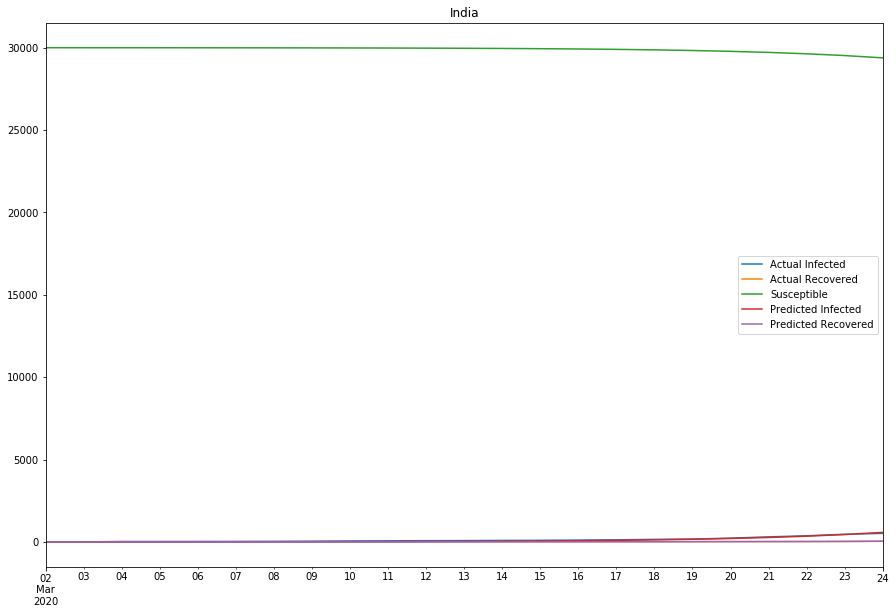

In [111]:
train(recovered, infected, data)

#### Lockdown Period

In [112]:
dbd_tc_param.head(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
0,2020-03-25,657,43,11,603
1,2020-03-26,730,50,16,664


In [113]:
dbd_tc_param.tail(2)

,Date,Total Confirmed,Total Recovered,Total Deceased,Total Active Cases
24,2020-04-18,15724,2466,521,12737
25,2020-04-19,17304,2854,559,13891


In [114]:
data = dbd_tc_param.set_index('Date')['Total Active Cases']
infected = dbd_tc_param.set_index('Date')['Total Confirmed']
recovered = dbd_tc_param.set_index('Date')['Total Recovered']

#### Best Case Scenario

In [115]:
s_0 = 75000
i_0 = 603
r_0 = 43

In [116]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [129]:
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-04-20', periods=240)))))

In [130]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = pres_fut
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

In [131]:
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.000001, 0.5), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Actual Infected': extended_actual, 'Actual Recovered': extended_recovered, 'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('Expected COVID19 Scenario in India for next 6 months (Best Case Scenario) ')
    df.plot(ax=ax)
    print(f"country=India, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    fig.savefig(f"LD India.png")

      fun: 140.69849834953365
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02017657, -0.03765876])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 10
   status: 0
  success: True
        x: array([0.15858943, 0.02195618])
country=India, beta=0.15858943, gamma=0.02195618, r_0:7.22299597


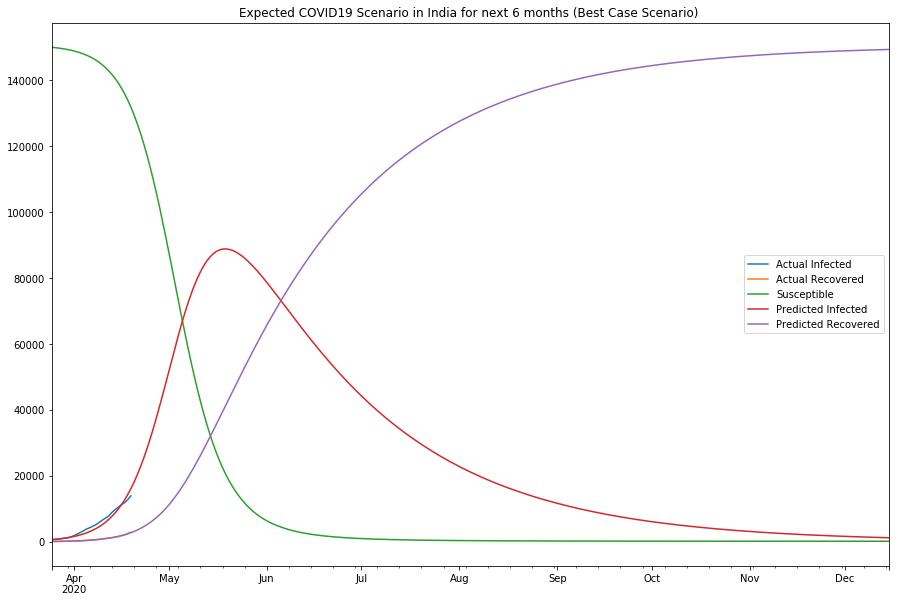

In [132]:
train(recovered, infected, data)

#### Worst Case Scenario

In [133]:
s_0 = 150000
i_0 = 603
r_0 = 43

In [134]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [139]:
pres_fut = np.array(list(data.index.values)+ list((np.array(pd.date_range('2020-04-20', periods=240)))))

In [140]:
def predict(beta, gamma, data, recovered, s_0, i_0, r_0):
    new_index = pres_fut
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s_0, beta*S*I/s_0-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
    return new_index, extended_actual, extended_recovered, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))

In [143]:
def train(recovered, infected, data):
    recovered = recovered
    infected = infected
    data = data

    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.000001, 0.5), (0.00000001, 0.4)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, prediction = predict(beta, gamma, data, recovered, s_0, i_0, r_0)
    df = pd.DataFrame({'Actual Infected': extended_actual, 'Actual Recovered': extended_recovered, 'Susceptible': prediction.y[0], 'Predicted Infected': prediction.y[1], 'Predicted Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('Expected COVID19 Scenario in India (Worst Case Scenario)')
    df.plot(ax=ax)
    print(f"country=India, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    fig.savefig(f"LD India.png")

      fun: 140.69849834953365
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02017657, -0.03765876])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 10
   status: 0
  success: True
        x: array([0.15858943, 0.02195618])
country=India, beta=0.15858943, gamma=0.02195618, r_0:7.22299597


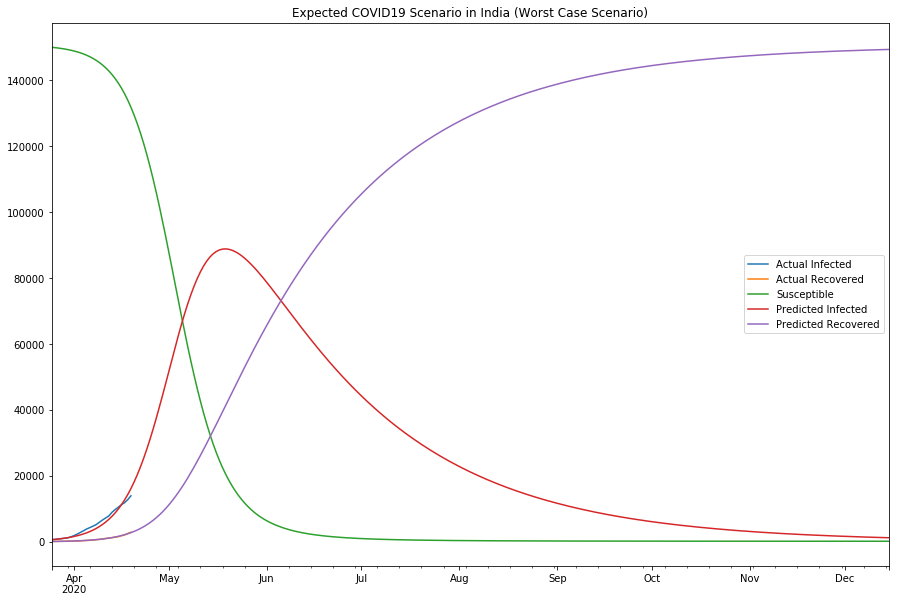

In [144]:
train(recovered, infected, data)

#### Due to lockdown following improvements happened:

- **Beta reduced by 41%** 
- **R0 reduced by 53%**